# **ResNet - Residual Learning**

# Given

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def resize_and_cast(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.image.resize(x, (128, 128))
    return x, y

In [7]:
def plot_augmented_images(image):
    augmented, _ = zip(*[augment(image, None) for i in range(7)])
    out = np.concatenate([resize_and_cast(image, None)[0]] + list(augmented), axis=1)
    plt.figure(figsize=(16, 2), dpi=128)
    plt.imshow(out)

In [3]:
builder = tfds.builder('imagenette/160px-v2')
builder.download_and_prepare()
raw_train_ds, raw_valid_ds = builder.as_dataset(['train', 'validation'], as_supervised=True)

train_ds = raw_train_ds.map(resize_and_cast).shuffle(10000).batch(256).prefetch(4)
valid_ds = raw_valid_ds.map(resize_and_cast).batch(256).prefetch(4)

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0.incompleteA6PXAO/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0.incompleteA6PXAO/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px-v2/0.1.0. Subsequent calls will reuse this data.


# Exercise 1: Residual Block (14 Points)

In this exercise you are going to implement a residual block. As you can see in the picture below a residual block consists of two convolution layers and a skip connection. For this exercise you should implement skip connections using **post-activation**. 
![](https://drive.google.com/uc?export=view&id=1mL5kzbMlmL_1bvCposZm-xcaiq1wSVTH)

## a) Implement the residual block using projection shortcut. (7 Points)

In [ ]:
from tensorflow.keras.layers import Conv2D, ReLU, add, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Add

def residual_block(input_layer, nb_filters, projection_shortcut=False):
  # each first residual block of a group (e.g. the first blue residual block in the image) should do
  # projection shortcut before adding input_layer (skip connection) and the output of this layer.
  skip_data = input_layer
  if (True == projection_shortcut):
      temp_ouput = tf.keras.layers.Conv2D(nb_filters,(3,3),strides=(2,2),padding="same" , activation=None)(input_layer)
  if (False == projection_shortcut):
      temp_ouput = tf.keras.layers.Conv2D(nb_filters,(3,3),strides=(1,1),padding="same" , activation=None)(input_layer)
  print(temp_ouput)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
  print(temp_norm_output)
  temp_norm_output = tf.keras.activations.relu(temp_norm_output)

  # post-activation
  temp_ouput = tf.keras.layers.Conv2D(nb_filters,(3,3),strides=(1,1),padding="same" , activation=None)(temp_norm_output)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
    

  # do projection shortcut here
  if (True == projection_shortcut):
    skip_data = tf.keras.layers.Conv2D(nb_filters,(1,1),strides=(2,2),padding="same" , activation='relu')(skip_data)
    skip_data = tf.keras.layers.BatchNormalization()(skip_data)
  
  print(skip_data)
  print(temp_norm_output)
  # add skip connection
  input_layer  = Add()([temp_norm_output , skip_data])

  input_layer = tf.keras.activations.relu(input_layer)
  # return outputs
  outputs = input_layer
  return outputs

## b) Implement the residual block using bottleneck layer. (5 Points)

In [ ]:
def residual_block_bottleneck(input_layer, nb_filters, projection_shortcut=False):
  # each first residual block of a group (e.g. the first blue residual block in the image) should do
  # projection shortcut before adding input_layer (skip connection) and the output of this layer.
    
  # bottleneck here
  skip_data = input_layer
  if (True == projection_shortcut):
    temp_ouput = tf.keras.layers.Conv2D(nb_filters/2,(1,1),strides=(2,2),padding="same" , activation=None)(input_layer)
  if (False == projection_shortcut):  
    temp_ouput = tf.keras.layers.Conv2D(nb_filters/2,(1,1),strides=(1,1),padding="same" , activation=None)(input_layer)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
  temp_norm_output = tf.keras.activations.relu(temp_norm_output)

  # 3X3 Conv Layer
  temp_ouput = tf.keras.layers.Conv2D(nb_filters/2,(3,3),strides=(1,1),padding="same" , activation=None)(temp_norm_output)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
  temp_norm_output = tf.keras.activations.relu(temp_norm_output)


  # post-activation
  temp_ouput = tf.keras.layers.Conv2D(nb_filters,(1,1),strides=(1,1),padding="same" , activation=None)(temp_norm_output)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
    

  # do projection shortcut here
  if (True == projection_shortcut):
    skip_shortucut_ouput = tf.keras.layers.Conv2D(nb_filters,(1,1),strides=(2,2),padding="same" , activation='relu')(skip_data)
    skip_shortucut_ouput = tf.keras.layers.BatchNormalization()(skip_shortucut_ouput)

  # add skip connection
  input_layer  = Add()[temp_norm_output , skip_shortucut_ouput]

  input_layer = tf.keras.activations.relu(input_layer)
  
  # return outputs
  outputs = input_layer
  return outputs

## c) Implement the residual block using pre-activation and bottleneck layer. (2 Points)

In [ ]:
def residual_block_preactivation(input_layer, nb_filters, projection_shortcut=False):
  # each first residual block of a group (e.g. the first blue residual block in the image) should do
  # projection shortcut before adding input_layer (skip connection) and the output of this layer.
    
   # bottleneck here

  #not sure about the factor by which reduction should be done in bottle neck hence for now just dividing by 4 

  skip_data = input_layer
  input_layer = tf.keras.layers.BatchNormalization()(input_layer)
  input_layer = tf.keras.activations.relu(input_layer)
  if (True == projection_shortcut):
    temp_ouput = tf.keras.layers.Conv2D(nb_filters/2,(1,1),strides=(2,2),padding="same" , activation=None)(input_layer)
  if (False == projection_shortcut):
    temp_ouput = tf.keras.layers.Conv2D(nb_filters/2,(1,1),strides=(2,2),padding="same" , activation=None)(input_layer)

  # 3X3 Conv Layer
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
  temp_norm_output = tf.keras.activations.relu(temp_norm_output)
  temp_norm_output = tf.keras.layers.Conv2D(nb_filters/2,(3,3),strides=(1,1),padding="same" , activation=None)(temp_norm_output)
  


  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_norm_output)
  temp_norm_output = tf.keras.activations.relu(temp_norm_output)
  temp_ouput = tf.keras.layers.Conv2D(nb_filters,(1,1),strides=(1,1),padding="same" , activation=None)(temp_norm_output)
  
    

  # do projection shortcut here
  if (True == projection_shortcut):
    skip_shortucut_ouput = tf.keras.layers.BatchNormalization()(skip_data)
    skip_shortucut_ouput = tf.keras.activations.relu(skip_shortucut_ouput)
    skip_shortucut_ouput = tf.keras.layers.Conv2D(nb_filters,(1,1),strides=(2,2),padding="same" , activation=None)(skip_shortucut_ouput)
    
  print(numpy.array(temp_norm_output).shape)
  # add skip connection
  input_layer  = Add()[temp_norm_output , skip_shortucut_ouput]

  # return outputs
  outputs = input_layer
  return outputs

# Exercise 2: Setting up ResNet34 (10 Points)

In this exercise you should construct a ResNet34 shown below. It consists of 16 residual blocks. Some of the residual blocks can be grouped together since the have the same number of features. As you can see in the picture the number of feature channels increase with each group `[64,128,256,512]`
![](https://drive.google.com/uc?export=view&id=1IqY-xa7SxoEinTPl_xJrfDHLfhA3n_qo)
The next code cell already imports all layers necessary to build ResNet34. You will also need one of the resnet_block methods you have implemented in exercise 1. Built the architecture of ResNet34 shown in this image.

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout , Flatten
from tensorflow.keras import activations
import numpy
def resnet34(input_layer, num_classes):
  # TODO
  # 34 layers = 1 conv7x7 + 32 conv3x3 layers + 1 dense layer
  # don't forget bn, relu, pooling and avg pooling  
  
  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(input_layer)
  x = BatchNormalization()(x)
  x = activations.relu(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  print(x)
  x = residual_block(x , 64 , False)
  x = residual_block(x , 64 , False)
  x = residual_block(x , 64 , False)

  x = residual_block(x , 128 , True)
  x = residual_block(x , 128 , False)
  x = residual_block(x , 128 , False)
  x = residual_block(x , 128 , False)

  x = residual_block(x , 256 , True)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)

  x = residual_block(x , 512 , True)
  x = residual_block(x , 512 , False)
  x = residual_block(x , 512 , False)
  print(x)
  x = GlobalAveragePooling2D()(x)

  x = Flatten()(x)
  x = Dense(num_classes, activation='softmax')(x) #multi-class

  # the last layer of the network is the classification module.
  return x

# this is for testing whether you model is valid.
inputs = Input(shape=(224, 224, 3))
outputs = resnet34(input_layer=inputs, num_classes=1000)

model = Model(inputs=inputs, outputs=outputs, name="ResNet34")
model.summary()

Tensor("max_pooling2d/MaxPool:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("conv2d_1/BiasAdd:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("batch_normalization/cond/Identity:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("batch_normalization_1/cond/Identity:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("conv2d_3/BiasAdd:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("batch_normalization_2/cond/Identity:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("Relu_2:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("batch_normalization_3/cond/Identity:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("conv2d_5/BiasAdd:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("batch_normalization_4/cond/Identity:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("Relu_4:0", shape=(None, 54, 54, 64), dtype=float32)
Tensor("batch_normalization_5/cond/Identity:0", shape=(None, 54, 54, 64), dty

# Exercise 3: Train your ResNet (5 Points)

In this exercise you will finally put everything together and train a ResNet on the Imagenette dataset. The dataset is already prepared as a `tf.Dataset` in `train_ds` and `valid_ds`
You need to setup your network by providing it an input layer. For training you can use:

```
history = model.fit()
```
You can find the API documentation for this [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit). We want to train the network for around 60 epochs using the Adam optimizer. For validation use the `valid_ds` given above.


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam

# build and compile the model.

# loss -> sparse_categorical_crossentropy
# optimizer -> adam
# metric -> accuracy

#for image_batch, labels_batch in train_ds:
 # print(image_batch.shape)
  #print(labels_batch.shape)
  #break
inputs = Input(shape=(128, 128, 3))
outputs = resnet34(input_layer=inputs, num_classes=1000)

model = Model(inputs=inputs, outputs=outputs, name="ResNet34")
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history  = model.fit(train_ds,
          validation_data=valid_ds,
          epochs=60)
# train the model

Tensor("max_pooling2d_2/MaxPool:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("conv2d_73/BiasAdd:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_70/cond/Identity:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_71/cond/Identity:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("conv2d_75/BiasAdd:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_72/cond/Identity:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("Relu_68:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_73/cond/Identity:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("conv2d_77/BiasAdd:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_74/cond/Identity:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("Relu_70:0", shape=(None, 30, 30, 64), dtype=float32)
Tensor("batch_normalization_75/cond/Identity:0", shape=(None,

37/37 [==============================] - 33s 885ms/step - loss: 6.7635 - accuracy: 0.1523 - val_loss: 6.8053 - val_accuracy: 0.1042
Epoch 2/60
37/37 [==============================] - 32s 868ms/step - loss: 6.6749 - accuracy: 0.2358 - val_loss: 6.7652 - val_accuracy: 0.1439
Epoch 3/60
37/37 [==============================] - 32s 867ms/step - loss: 6.6465 - accuracy: 0.2633 - val_loss: 6.7629 - val_accuracy: 0.1470
Epoch 4/60
37/37 [==============================] - 32s 866ms/step - loss: 6.6392 - accuracy: 0.2713 - val_loss: 6.7107 - val_accuracy: 0.1990
Epoch 5/60
37/37 [==============================] - 32s 868ms/step - loss: 6.6496 - accuracy: 0.2600 - val_loss: 6.7436 - val_accuracy: 0.1661
Epoch 6/60
37/37 [==============================] - 32s 866ms/step - loss: 6.6228 - accuracy: 0.2869 - val_loss: 6.7557 - val_accuracy: 0.1536
Epoch 7/60
37/37 [==============================] - 32s 865ms/step - loss: 6.6118 - accuracy: 0.3000 - val_loss: 6.8064 - val_accuracy: 0.1029
Epoch 8/60

## Plot training history

Highest Validation Accuracy: 0.5943949222564697


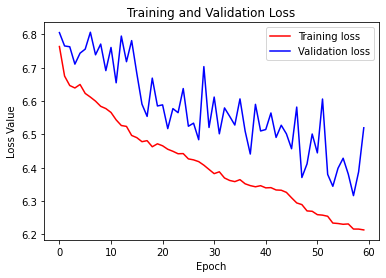

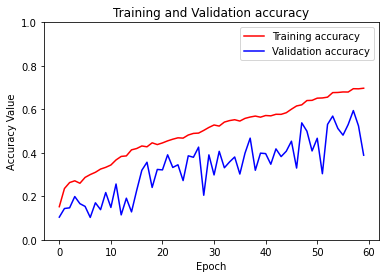

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(f'Highest Validation Accuracy: {np.max(val_accuracy)}')
eps = range(60)

plt.figure()
plt.plot(eps, loss, 'r', label='Training loss')
plt.plot(eps, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure()
plt.plot(eps, accuracy, 'r', label='Training accuracy')
plt.plot(eps, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Exercise 4: Improve your model (10 Points)
With the plain ResNet34 from Exercise 3 you should be able to reach a validation accuracy of above 70% already. You may also note that the validation performance is generally rather unstable. Try to add some improvements to the model or the training in order to push above 80% validation accuracy. 
Some suggestions on ways to improve performance are listed below. Always make sure to tune your learning rate.

Note that to receive points in this exercise you can do any improvements that you like and you are not bound to the suggestions below, just make sure to reason about your changes and report how it affected the performance. 
Keep a log of what you have tried and how good the results were at the bottom of this notebook. Points will be given for achieved validation accuracy, correct implementation of sensible techniques and systematic logging of experiments and their results. 




### Data Augmentation
Add some data augmentation to the training dataset. You can use methods from `tf.image`. Make sure the resulting images are of shape `(128, 128, 3)` after your transform. Experiment with your transforms to improve the model.

Make sure to build your new `train_ds` from the `raw_train_ds`. The current `train_ds` only makes use of the `resize_and_cast` function at the beginning of the notebook, shuffling and batching. You can use the cell with the `plot_augmented_images` to inspect how your data looks like.

In [5]:
def augment(x, y):
    ''' Augments the training images

    Args:
        x (np.array): Image of shape (H, W, C)
        label (int): Label classifying the image

    Returns:
        im, label (np.array, int): Tuple of augmented image and label
    '''
    
    x, _ = resize_and_cast(x, None)
    x = tf.image.adjust_brightness(x,0.3)
    x = tf.image.adjust_hue(x,0.2)
    x = tf.image.adjust_contrast(x, 0.3)
    x = tf.image.adjust_saturation(x , 0.6)
    print(x)
    return x, y

train_ds_aug = raw_train_ds.map(augment).shuffle(10000).batch(256).prefetch(4)
ds_it = iter(raw_train_ds)

Tensor("adjust_saturation/Identity:0", shape=(128, 128, 3), dtype=float32)


tf.Tensor(
[[[0.75877166 0.7673489  0.7674476 ]
  [0.8598924  0.8684697  0.86856836]
  [0.85067827 0.85925555 0.8593542 ]
  ...
  [0.90729994 0.9215242  0.9230347 ]
  [0.90729994 0.9215242  0.9230347 ]
  [0.90729994 0.9215242  0.9230347 ]]

 [[0.78780544 0.7963827  0.7964814 ]
  [0.77657783 0.7851551  0.78525376]
  [0.79380155 0.8023788  0.8024775 ]
  ...
  [0.90729994 0.9215242  0.9230347 ]
  [0.90729994 0.9215242  0.9230347 ]
  [0.90729994 0.9215242  0.9230347 ]]

 [[0.87750846 0.88608575 0.8861844 ]
  [0.8655571  0.8741343  0.874233  ]
  [0.8622844  0.87086165 0.87096035]
  ...
  [0.90729994 0.9215242  0.9230347 ]
  [0.90729994 0.9215242  0.9230347 ]
  [0.90729994 0.9215242  0.9230347 ]]

 ...

 [[0.68553776 0.7031849  0.70009005]
  [0.68492734 0.70240074 0.69944483]
  [0.68335176 0.70117605 0.69785124]
  ...
  [0.6372378  0.65082335 0.64877355]
  [0.6351975  0.6484336  0.6468382 ]
  [0.63745    0.650686   0.64909065]]

 [[0.69863933 0.71234965 0.7037031 ]
  [0.70085824 0.7140127  0

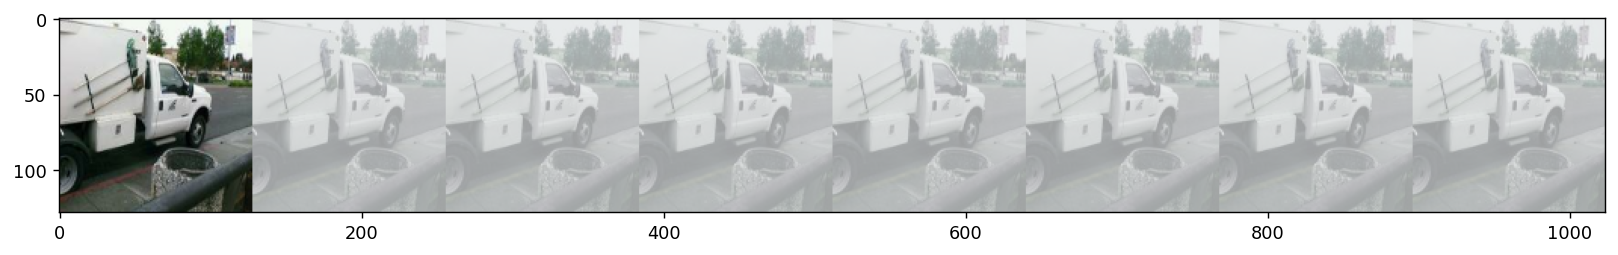

In [8]:
# Rerun this cell to plot examples of your current augment: left show original resized, then 7 augmented versions
x, _ = next(ds_it)
plot_augmented_images(x)

### Regularization Techniques
In order to improve generalization, experiment with some regularization techniques like weight regularization or Dropout and see if it improves your model.

You can copy paste the previous `residual_block` and `resnet34` methods here and modify them with your tweaks.

In [10]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout , Flatten , Add, BatchNormalization
from tensorflow.keras import activations

def residual_block(input_layer, nb_filters, projection_shortcut=False):
  skip_data = input_layer
  if (True == projection_shortcut):
      temp_ouput = tf.keras.layers.Conv2D(nb_filters,(3,3),strides=(2,2),padding="same" , activation=None , kernel_regularizer=L2(0.01))(input_layer)
  if (False == projection_shortcut):
      temp_ouput = tf.keras.layers.Conv2D(nb_filters,(3,3),strides=(1,1),padding="same", activation=None , kernel_regularizer=L2(0.01))(input_layer)
  #print(temp_ouput)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
  #print(temp_norm_output)
  temp_norm_output = tf.keras.activations.relu(temp_norm_output)

  # post-activation
  temp_ouput = tf.keras.layers.Conv2D(nb_filters,(3,3),strides=(1,1),padding="same", activation=None)(temp_norm_output)
  temp_norm_output = tf.keras.layers.BatchNormalization()(temp_ouput)
    

  # do projection shortcut here
  if (True == projection_shortcut):
    skip_data = tf.keras.layers.Conv2D(nb_filters,(1,1),strides=(2,2),padding="same", activation=None)(skip_data)
    skip_data = tf.keras.layers.BatchNormalization()(skip_data)

  
  #print(skip_data)
  #print(temp_norm_output)
  # add skip connection
  input_layer  = Add()([temp_norm_output , skip_data])

  input_layer = tf.keras.activations.relu(input_layer)
  # return outputs
  outputs = input_layer
  return outputs

def resnet34(input_layer, num_classes):
  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2) , activation='relu' , kernel_regularizer =L2(0.01))(input_layer)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  print(x)
  x = residual_block(x , 64 , False)
  x = residual_block(x , 64 , False)
  x = residual_block(x , 64 , False)

  x = residual_block(x , 128 , True)
  x = residual_block(x , 128 , False)
  x = residual_block(x , 128 , False)
  x = residual_block(x , 128 , False)

  x = residual_block(x , 256 , True)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)
  x = residual_block(x , 256 , False)

  x = residual_block(x , 512 , True)
  x = residual_block(x , 512 , False)
  x = residual_block(x , 512 , False)
  print(x)
  x = GlobalAveragePooling2D()(x)

  x = Flatten()(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x) #multi-class

  # the last layer of the network is the classification module.
  return x

### Train with Tweaks
To stabilize training and converge better we want to use a learning rate schedule. A learning rate schedule is used to modify the learning rate throughout training, usually reducing the learning rate to converge better.
Keras offers an [API](https://keras.io/api/callbacks/learning_rate_scheduler/#learningratescheduler) to implement learning rate schedules that can be passed as callbacks. A simple schedule that reduces the learning rate when the loss has not decreased for a certain amount of time is the [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) schedule.

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
inputs = Input(shape=(128, 128, 3))
outputs = resnet34(input_layer=inputs, num_classes=1000)

model_1 = Model(inputs=inputs, outputs=outputs, name="ResNet34")
model_1.summary()

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
history  = model_1.fit(train_ds,
          validation_data=valid_ds,
          epochs=60  , callbacks = [reduce_lr])


KerasTensor(type_spec=TensorSpec(shape=(None, 30, 30, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 512), dtype=tf.float32, name=None), name='tf.nn.relu_63/Relu:0', description="created by layer 'tf.nn.relu_63'")
Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 61, 61, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 30, 30, 64)

### Plot Training History

Highest Validation Accuracy: 0.7082802653312683


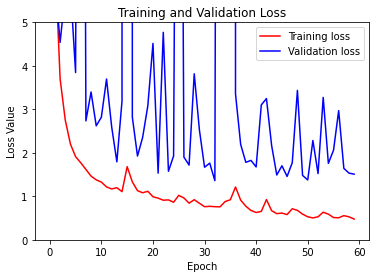

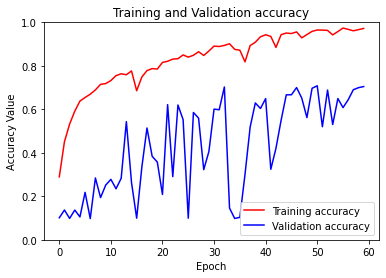

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(f'Highest Validation Accuracy: {np.max(val_accuracy)}')

eps = range(60)

plt.figure()
plt.plot(eps, loss, 'r', label='Training loss')
plt.plot(eps, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure()
plt.plot(eps, accuracy, 'r', label='Training accuracy')
plt.plot(eps, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Experiment Log
Example:
- LR 3.14, slight dropout and fancy augmentations
    - unstable training, accuracy 42%


Even if you don't get your model to work perfectly, you can reach a lot of points by showing off a proper experiment log showing your smart efforts to improve the model.

Experiment log 

  1. only data augmentation no regularization 
     
	 Result : Training accuracy decreased down to 40% , validation accuracy also showed bad results 
	 Analysis : I think there was too much of the augmentation performed on data due to which data lost its originality, which resilted in underfitting of data 
	 
  2. No data augmentation and regularization in each layer
     
	 Result : Training accuracy decreased down to 30% , validation accuracy also showed bad results 15%
	 Analysis : After adding regularization there was underfitting of data while training because there were weight regulaizer of every single weight (parameter)
	 
  3. Adding regularization in only first layer of each block 

     Result : Training accuracy 70% , and validation accuracy close to 60% 
	 Analysis : This experiment did not showed much improvement in comparision older model without any regularization

  4. Adding regularization in first layer of each block and in first conv layer of model , also adding  dropout before dense layer 

     Result : Training accuracy 97% , validation 70% 
     
     Analysis : This experiment increased the training accuracy by 27 % and validation accuracy by 10% when compared to older model. Although it can be seen as a bit overfitting but it is also true that it increased validation accuracy	 